In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import time

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from scipy import stats


In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

In [3]:
os.chdir(r"C:\Users\jadel\Documents\OpenClassrooms\Projet 3")

In [4]:
#chargement du fichier csv cleané dans le notebook précédent
df = pd.read_csv("consommation_seattle.csv", sep = ',')

In [5]:
df.columns

Index(['DataYear', 'YearBuilt', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'BuildingType', 'PrimaryPropertyType',
       'LargestPropertyUseType', 'ENERGYSTARScore', 'SteamUse%',
       'Electricity%', 'NaturalGas%', 'TotalGHGEmissions',
       'SiteEnergyUse(kBtu)'],
      dtype='object')

In [6]:
df.isna().sum().sum()
#pas de nans

0

In [7]:
#changement des catégories pour optimiser les processeurs
dic_types = {'BuildingType': 'category',
            'PrimaryPropertyType': 'category',
            'NumberofFloors' : 'int',
            'LargestPropertyUseType' : 'category'}

df = df.astype(dic_types, errors = 'ignore')

In [8]:
#dichotomisation des colonnes catégorielles
df = pd.get_dummies(df, columns = ['BuildingType', 'PrimaryPropertyType','LargestPropertyUseType'])

In [9]:
df.head()

,DataYear,YearBuilt,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SteamUse%,Electricity%,NaturalGas%,TotalGHGEmissions,SiteEnergyUse(kBtu),BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_SPS-District K-12,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_High-Rise Multifamily,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mid-Rise Multifamily,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Non-Refrigerated Warehouse,PrimaryPropertyType_Other,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket/Grocery Store,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,LargestPropertyUseType_Distribution Center,LargestPropertyUseType_Hospital (General Medical & Surgical),LargestPropertyUseType_Hotel,LargestPropertyUseType_K-12 School,LargestPropertyUseType_Medical Office,LargestPropertyUseType_Multifamily Housing,LargestPropertyUseType_Non-Refrigerated Warehouse,LargestPropertyUseType_Office,LargestPropertyUseType_Other,LargestPropertyUseType_Parking,LargestPropertyUseType_Refrigerated Warehouse,LargestPropertyUseType_Residence Hall/Dormitory,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Worship Facility
0,2015,1927,12,0.000000,11.390023,65.0,3.40053,52.80,18.22,5.523179,15.758764,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2015,1996,11,9.620129,11.390792,51.0,0.00000,46.75,53.25,5.577879,15.938279,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2015,1969,41,0.000000,13.776760,18.0,3.32791,68.04,5.07,7.631664,18.107758,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2015,1980,18,9.430359,11.584604,67.0,0.00000,40.91,59.09,6.231858,16.512102,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2015,1926,11,0.000000,11.326704,25.0,0.00000,42.85,57.15,5.344533,15.648547,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
df.shape

(4995, 53)

In [27]:
#on commence à effectuer la prédiction de la consommation éléctrique
X_train = df.loc[df['DataYear']==2015].drop(['DataYear', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], axis=1)
X_test = df.loc[df['DataYear']==2016].drop(['DataYear', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], axis=1)
y_train = df.loc[df['DataYear']==2015]['SiteEnergyUse(kBtu)']
y_test = df.loc[df['DataYear']==2016]['SiteEnergyUse(kBtu)']

In [28]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)

DummyRegressor()

In [14]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [15]:
param_grid_rf = { 'max_depth': [4,6,8],
              'max_features': ['auto', 'log2', 'sqrt'], 'n_estimators': [2000]}


rf = RandomForestRegressor()
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error',return_train_score=True, n_jobs = -1)
t0=time.time()
grid_search_rf.fit(X_train, y_train)
print("Execution time :",time.time()-t0,"secondes")
grid_search_rf.best_params_

Execution time : 246.460595369339 secondes


{'max_depth': 8, 'max_features': 'auto', 'n_estimators': 2000}

In [16]:
param_grid_gbr = {'n_estimators' : [5000],
                    'max_depth' : [7,8,10],
                    'learning_rate' : [0.01],
                    'validation_fraction' : [0,.3],
                    'min_samples_split' : [5, 15]}

gbr = GradientBoostingRegressor()
grid_search_gbr = GridSearchCV(gbr, param_grid_gbr, cv=5, scoring='neg_mean_squared_error',return_train_score=True, n_jobs = -1)
t0=time.time()
grid_search_gbr.fit(X_train, y_train)
print("Execution time :",time.time()-t0,"secondes")
grid_search_gbr.best_params_

Execution time : 2633.9209694862366 secondes


{'learning_rate': 0.01,
 'max_depth': 7,
 'min_samples_split': 15,
 'n_estimators': 5000,
 'validation_fraction': 0}

In [17]:
param_grid_svr = [{'kernel' :['poly'],
                'C' : [.1,1,100],
                   'degree' : [5,7]},
                  {'kernel' :['sigmoid'],
                'C' : [.1,1,100]},
                   {'kernel' :['rbf'],
               'gamma' : [1,0.1,0.01],
                'C' : [.1,1,100]}]

svr = SVR()
grid_search_svr = GridSearchCV(svr, param_grid_svr, cv=5, scoring='neg_mean_squared_error',return_train_score=True, n_jobs=-1)
t0=time.time()
grid_search_svr.fit(X_train, y_train)
print("Execution time :",time.time()-t0,"secondes")
grid_search_svr.best_params_

Execution time : 44.89533233642578 secondes


{'C': 0.1, 'kernel': 'sigmoid'}

In [18]:
def exp_trans(x):
    return np.exp(x)-1

In [29]:
y_test = exp_trans(y_test)
y_train = exp_trans(y_train)

In [55]:
def print_perf(model, model_name, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    y_pred_train = model.predict(X_train)
    y_pred_train = exp_trans(y_pred_train)
    y_pred_test = model.predict(X_test)
    y_pred_test = exp_trans(y_pred_test)
    print(f"{model_name} RMSE train : {mean_squared_error(y_pred_train, y_train, squared = False):n}")
    print(f"{model_name} RMSE test : {mean_squared_error(y_pred_test, y_test, squared = False):n}, refit time: {model.refit_time_:.2f}")
    print(f"{model_name} MAE test : {mean_absolute_error(y_pred_test, y_test):n}\n")

In [56]:
def print_perf_2(model, model_name, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    y_pred_train = model.predict(X_train)
    y_pred_train = exp_trans(y_pred_train)
    y_pred_test = model.predict(X_test)
    y_pred_test = exp_trans(y_pred_test)
    print(f"{model_name} RMSE train : {mean_squared_error(y_pred_train, y_train, squared = False):n}")
    print(f"{model_name} RMSE test : {mean_squared_error(y_pred_test, y_test, squared = False):n}")
    print(f"{model_name} MAE test : {mean_absolute_error(y_pred_test, y_test):n}\n")

In [57]:
print_perf_2(dummy_regr, 'Dummy Regressor')
print_perf_2(lin_reg, 'Linear Regression')
print_perf(grid_search_svr, 'SVR')
print_perf(grid_search_rf, 'Random Forest')
print_perf(grid_search_gbr, 'GBR')


#Le GBR affiche le meilleur résultat sur les données de test

Dummy Regressor RMSE train : 1.42866e+07
Dummy Regressor RMSE test : 1.4556e+07
Dummy Regressor MAE test : 3.89772e+06

Linear Regression RMSE train : 6.65753e+06
Linear Regression RMSE test : 6.92165e+06
Linear Regression MAE test : 1.33439e+06

SVR RMSE train : 1.25268e+07
SVR RMSE test : 1.28303e+07, refit time: 0.26
SVR MAE test : 2.19686e+06

Random Forest RMSE train : 5.13745e+06
Random Forest RMSE test : 6.28208e+06, refit time: 20.15
Random Forest MAE test : 1.2602e+06

GBR RMSE train : 251487
GBR RMSE test : 4.28784e+06, refit time: 41.36
GBR MAE test : 753032



In [40]:
def confidence(model, model_name, confidence, y_test=y_test):
    y_pred = model.predict(X_test)
    y_pred = exp_trans(y_pred)
    squared_errors = (y_pred - y_test)**2
    print(f"Intervalle de confiance {confidence*100}% de {model_name}: {np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))}")

In [41]:
confidence(lin_reg, 'Linear Regression', .95)
confidence(grid_search_svr, 'SVR', .95)
confidence(grid_search_rf, 'Random Forest', .95)
confidence(grid_search_gbr, 'GBR', 0.95)

<ipython-input-40-ab758d2f41a3>:5: RuntimeWarning: invalid value encountered in sqrt
  print(f"Intervalle de confiance {confidence*100}% de {model_name}: {np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))}")


Intervalle de confiance 95.0% de Linear Regression: [              nan 10143003.33326944]
Intervalle de confiance 95.0% de SVR: [ 8028501.64931276 16271996.6262945 ]
Intervalle de confiance 95.0% de Random Forest: [1994726.5562423  8657380.02368349]
Intervalle de confiance 95.0% de GBR: [             nan 6208326.87830404]


<ipython-input-40-ab758d2f41a3>:5: RuntimeWarning: invalid value encountered in sqrt
  print(f"Intervalle de confiance {confidence*100}% de {model_name}: {np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))}")


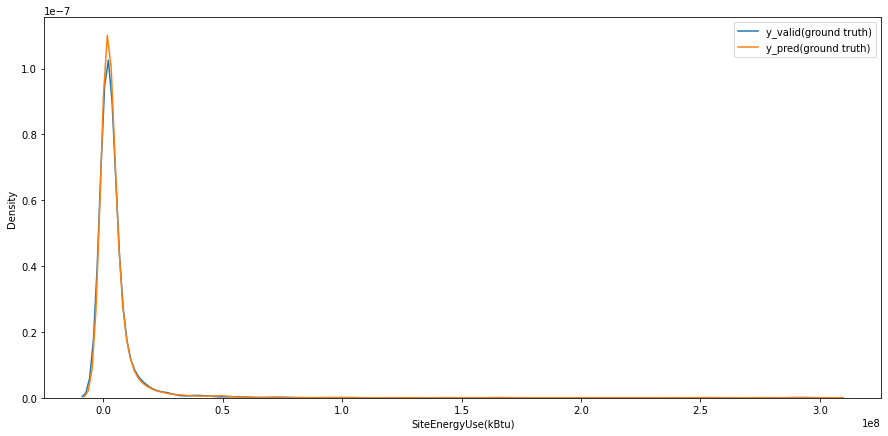

In [39]:
y_pred = grid_search_gbr.predict(X_test)
y_pred = exp_trans(y_pred)

plt.figure(figsize=(15,7))
sns.kdeplot(y_test, label='y_valid(ground truth)')
sns.kdeplot(y_pred, label='y_pred(ground truth)')
plt.legend();

#Les deux courbes sont très proches

In [58]:
print(f"Les prédictions ont en moyenne une marge d'erreur de {(abs(y_pred-y_test)*100/y_test).mean():.2f}%") 

Les prédictions ont en moyenne une marge d'erreur de 18.34%
